# Information retrieval for movies recommendation

Database which the project it's based on:   
[HBO Max](https://www.kaggle.com/datasets/dgoenrique/hbo-max-movies-and-tv-shows)  

<div></div> 

In [55]:
import numpy as np 
import pandas as pd
from toolbox import preprocessing
import ast

In [56]:
# load
try: 
    pop_movies = pd.read_csv('../data/modified/popular_movies.csv.zip')['tmdbId']
except: 
# Load the "rating" and "link" with the id from multiple sources
    ratings = pd.read_csv('../data/origin/ratings.zip')
    links = pd.read_csv('../data/origin/links.zip')

    # Inner join between both files
    ratings = ratings.merge(links, how='inner', on='movieId')

    # Select only the movies with at least 750 reviews, to classify as popular enough for recommendation
    pop_movies = ratings['movieId'].value_counts().to_frame().query('count > 50').index
    pop_movies = links.query('movieId in @pop_movies')['tmdbId'].dropna()

    pop_movies.to_csv('../data/modified/popular_movies.csv.zip', index=False, compression='zip')

    del ratings, links

<div></div> 

## Leitura dos Arquivos

As bases vieram em formato CSV, portanto, só foi utilizado o pandas para leitura e feito um concat

<div></div> 

In [57]:
# Load the 'credits' dataset from a zipped CSV file
dt_c = pd.read_csv('../data/origin/credits.zip')

# Load the 'movies_metadata' dataset from a zipped CSV file
dt_m = pd.read_csv('../data/origin/movies_metadata.zip')

# Convert the 'id' column to numeric data type, ignoring any errors
dt_m['id'] = pd.to_numeric(dt_m['id'], errors='coerce')

# Convert the 'popularity' column to numeric data type, ignoring any errors
dt_m['popularity'] = pd.to_numeric(dt_m['popularity'], errors='coerce')

# Merge the 'movies_metadata' DataFrame with the 'credits' DataFrame based on the 'id' column
dt_m = dt_m.merge(dt_c.set_index('id'), how='left', left_on=['id'], right_index=True)

# Drop rows with missing values in the 'id' column
dt_m.dropna(subset=['id', 'overview'], inplace=True)

# Select the movies with the minimun engagement
dt_m.query('id in @pop_movies', inplace=True)

# Reset index 
dt_m.reset_index(drop=True, inplace=True)

# Delete the 'credits' DataFrame to free up memory
del dt_c

C:\Users\kevin\AppData\Local\Temp\ipykernel_18516\1593278502.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dt_m = pd.read_csv('../data/origin/movies_metadata.zip')


In [58]:
# Define the variables
v = 'vote_count'  # Vote count column
m = 'vote_count.quantile(0.85)'  # Quantile of vote count
R = 'vote_average'  # Vote average column
C = 'vote_average.mean()'  # Mean of vote average

# Evaluate the score using the defined variables and assign it to a new column 'score'
dt_m.eval(f'score = ({v}/({v}+{m}) * {R}) + ({m}/({m}+{v}) * {C})', inplace=True)

del v, m, R, C

In [59]:
dt_m.drop(['homepage', 'original_title', 'poster_path'], axis=1, inplace=True, errors='ignore')

In [60]:
dt_m['genres'] = dt_m['genres'].map(lambda genres: [genre.get('name').lower() for genre in ast.literal_eval(genres)])
dt_m['genres'] = dt_m['genres'].map(lambda genres: [genre.replace(' ', '_') for genre in genres])

In [61]:
dt_m['genres'].explode().value_counts()

genres
drama              6408
comedy             4499
thriller           2814
romance            2478
action             2405
crime              1673
adventure          1552
horror             1377
science_fiction    1222
family             1134
fantasy             976
mystery             918
animation           651
documentary         582
music               537
history             494
war                 412
western             249
foreign             147
tv_movie             71
Name: count, dtype: int64

### Identificação das query / docs

Foi feita uma separação do index das query, para pode fazer uma localização do na base origina após o TF-IDF, dado que o TF-IDF reseta os index dos termos por documento

In [62]:
import multiprocessing as mp
from gensim.models import Word2Vec


In [63]:
genres = dt_m['genres'].to_list()

In [119]:
model = Word2Vec(min_count=1,
                 window=5,
                 vector_size=15,
                 sample=5e-6, 
                 alpha=0.002, 
                 negative=50,
                 workers=mp.cpu_count()-1, 
                 seed=42, 
                 sg=1)

model.build_vocab(genres)
model.train(genres, total_examples=model.corpus_count, epochs=500, report_delay=1)

model.wv.most_similar(positive='romance', topn=20)

[('science_fiction', 0.9788143634796143),
 ('fantasy', 0.9660441875457764),
 ('drama', 0.9657939672470093),
 ('animation', 0.9653182625770569),
 ('crime', 0.96053147315979),
 ('comedy', 0.9595752954483032),
 ('action', 0.9580628275871277),
 ('horror', 0.9521360993385315),
 ('adventure', 0.9518252015113831),
 ('thriller', 0.9489524960517883),
 ('music', 0.9487782120704651),
 ('family', 0.9416791200637817),
 ('mystery', 0.935806393623352),
 ('history', 0.9139103889465332),
 ('war', 0.8972750902175903),
 ('tv_movie', 0.888428807258606),
 ('western', 0.8747095465660095),
 ('foreign', 0.6696580052375793),
 ('documentary', 0.6088672280311584)]

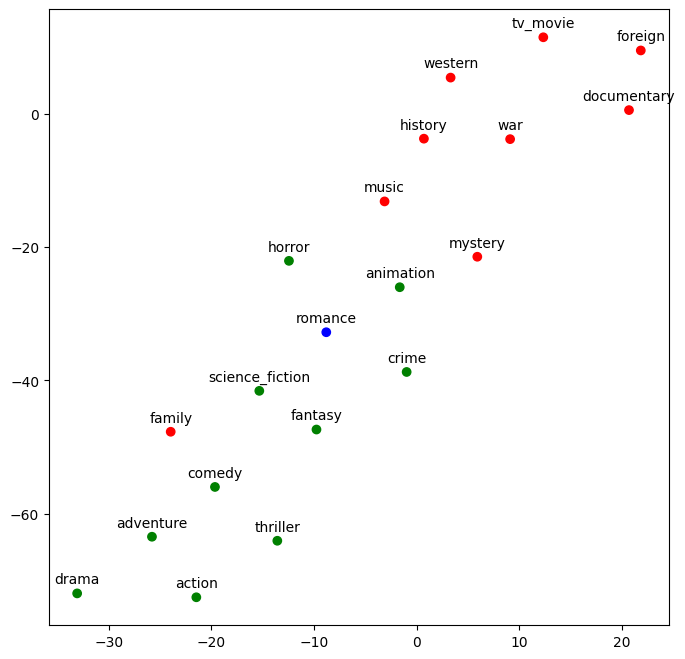

In [120]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def basic_plot(model, target:str, perp):
        word_vectors = model.wv.vectors
        words = model.wv.index_to_key

        pca = PCA(n_components=6, random_state=42)
        wv_pca = pca.fit_transform(word_vectors)

        tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
        wv_ts = tsne.fit_transform(wv_pca) 

        plot_df = pd.DataFrame({'word': words, 
                                'x': wv_ts[:, 0], 
                                'y': wv_ts[:, 1]})

        color_rule = [g[0] for g in model.wv.most_similar(target)]

        when = [plot_df['word'].isin(color_rule), 
                plot_df['word']==target]
        then = ['green', 'blue']

        plot_df['color'] = np.select(when, then, default='red')

        plt.figure(figsize=(8, 8))
        plt.scatter(x=plot_df['x'], 
                    y=plot_df['y'], 
                    c=plot_df['color'])
        for x, y, word in zip(plot_df['x'], plot_df['y'], plot_df['word']): 
                plt.annotate(word, xy=(x,y), xytext=(0, 15), textcoords='offset points', ha='center', va='top')
        plt.show()
        

basic_plot(model=model, target='romance', perp=8)

In [90]:
model.save('../models/genres_model')